In [1]:
import os
import sys
sys.path.append(os.getcwd())
import numpy as np

import re
import string
import _pickle as cPickle

def read_pickle(filepath, filename):

        f = open(os.path.join(filepath, filename), 'rb')
        read_file = cPickle.load(f)
        f.close()

        return read_file

def save_pickle(filepath, filename, data):

    f = open(os.path.join(filepath, filename), 'wb')
    cPickle.dump(data, f)
    print(" file saved to: %s"%(os.path.join(filepath, filename)))
    f.close()

In [2]:
# Prediction outputs from ProtoInfoMax++ model on sentiment classification ep=0
# ep=0 is obtained based on results at which 1-CER is the highest
t_probs, t_gts = read_pickle('../eval/', 'tprobs_gts_imax_kw_cls_all_0.pkl')

In [3]:
t_probs = t_probs.reshape((t_probs.shape[0], t_probs.shape[1]))
t_probs.shape

(1120, 2)

In [4]:
# ground truth targets for sentiment classification
t_gts

array(['0', '0', '0', ..., 'UNCONFIDENT_INTENT_FROM_SLAD',
       'UNCONFIDENT_INTENT_FROM_SLAD', 'UNCONFIDENT_INTENT_FROM_SLAD'],
      dtype='<U28')

### Get prediction outcomes for OOD examples

In [5]:
# Get prediction for OOD examples
ood_lbl_pt = np.where(t_gts=='UNCONFIDENT_INTENT_FROM_SLAD')
ood_labels = t_gts[ood_lbl_pt]
ood_probs = t_probs[ood_lbl_pt]
ood_probs_ = [max(ps) for ps in ood_probs]

In [6]:
# Average of probability outputs for OOD examples
np.mean(ood_probs_)

0.6675428

In [7]:
# tau (threshold) is obtained based on heuristic search
ood_pred = ['ood' if p<.814 else 'id' for p in ood_probs_]
ood_lbl = ['ood'] * len(ood_pred)

### Get prediction outcomes for ID examples

In [8]:
id_labels_pt0 = np.where(t_gts=='0')
id_labels_pt1 = np.where(t_gts=='1')

id_labels_pt=[]
id_labels_pt.extend(id_labels_pt0[0])
id_labels_pt.extend(id_labels_pt1[0])

id_labels = t_gts[id_labels_pt]
id_probs = t_probs[id_labels_pt]
id_probs = [[p if p>=0 else 0 for p in ps] for ps in id_probs]
id_labels = [int(i) for i in id_labels]

In [9]:
# Average of probability outputs for ID examples
np.mean(id_probs)

0.81753904

### Plotting

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from os.path import join

from cal_methods import HistogramBinning, TemperatureScaling
from betacal import BetaCalibration
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [11]:
# Imports to get "utility" package
import sys
from os import path
sys.path.append( path.dirname( path.dirname( path.abspath("utility") ) ) )
from utility.unpickle_probs import unpickle_probs
from utility.evaluation import get_bin_info, softmax

In [12]:
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins

    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.

    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.

    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }

In [13]:
def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    #ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt], loc='upper left')
    #ax.legend(handles=[gap_plt, acc_plt], loc='center right', bbox_to_anchor=(0.99, 0.3))

In [14]:

def _confidence_histogram_subplot_ood(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9, color="red")
   
    ax.set_xlim(0, 1)
    #ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(False)

    if draw_averages:
     
        ax.text(0.55, 25, "%.2f" % bin_data['avg_confidence'], color="black", 
                ha="center", va="center")
       
        ax.text(0.85, 25, "%.2f" % bin_data['avg_accuracy'], color="black", 
                ha="center", va="center")
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt,conf_plt])

In [15]:

def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9, color=(0.2, 0.4, 0.6, 0.6))
   
    ax.set_xlim(0, 1)
    #ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(False)

    if draw_averages:
        ax.text(0.6, 200, "%.2f" % bin_data['avg_accuracy'], color="black", 
                ha="center", va="center")
  
        ax.text(0.77, 210, "%.2f" % bin_data['avg_confidence'], color="black",
                ha="center", va="center")
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(np.int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig

In [16]:
def get_pred_conf(y_probs, normalize = False):
    
    y_preds = np.argmax(y_probs, axis=1)  # Take maximum confidence as prediction
    
    if normalize:
        y_confs = np.max(y_probs, axis=1)/np.sum(y_probs, axis=1)
    else:
        y_confs = np.max(y_probs, axis=1)  # Take only maximum confidence
        
    return y_preds, y_confs

In [17]:
def get_uncalibrated_res(probs, labels, M = 15):
    
    y_preds, y_confs = get_pred_conf(probs, normalize = False)
    labels = np.array(labels)
    
    return compute_calibration(labels, y_preds, y_confs, num_bins = M)

#### Binning OOD Prediction

In [18]:
ood_lbl = np.array(ood_lbl)
ood_pred = np.array(ood_pred)
ood_probs_ = np.array(ood_probs_)
bin_ood = compute_calibration(ood_lbl, ood_pred, ood_probs_, num_bins = 10)

In [19]:
bin_ood

{'accuracies': array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 0.1627907, 0.       ]),
 'confidences': array([0.05300884, 0.14364061, 0.21807539, 0.35878167, 0.4575291 ,
        0.55415547, 0.65655321, 0.75639242, 0.84548718, 0.92023683]),
 'counts': array([ 4,  2,  6, 14, 32, 40, 55, 76, 86,  4]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7617554858934169,
 'avg_confidence': 0.6696769814225947,
 'expected_calibration_error': 0.48325621329691715,
 'max_calibration_error': 0.9469911567866802}

#### Binning ID Prediction

In [20]:
bin_data = get_uncalibrated_res(id_probs, id_labels, M = 10)

In [21]:
bin_data

{'accuracies': array([0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.66666667, 0.64864865, 0.65178571, 0.68396226, 0.71627907]),
 'confidences': array([0.        , 0.        , 0.        , 0.        , 0.48672345,
        0.56006944, 0.66797447, 0.76367664, 0.85428113, 0.92243141]),
 'counts': array([  0,   0,   0,   0,   3,   9,  37, 112, 424, 215]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.685,
 'avg_confidence': 0.8466069823876023,
 'expected_calibration_error': 0.16400541994720697,
 'max_calibration_error': 0.20615233959153645}

#### Reliability Diagram

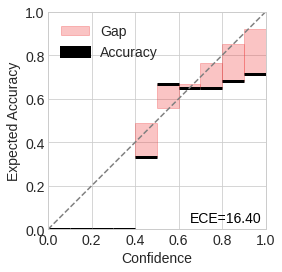

In [22]:
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots()
_reliability_diagram_subplot(ax, bin_data)
plt.show()

#### Confidence Histogram for ID Prediction

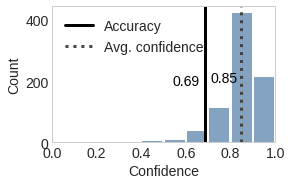

In [23]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(4,2.5))
_confidence_histogram_subplot(ax, bin_data)
plt.show()

#### Confidence HIstogram for OOD Prediction

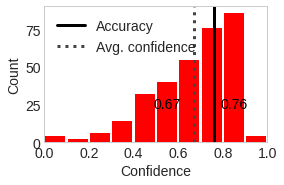

In [24]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(4,2.5))
_confidence_histogram_subplot_ood(ax, bin_ood)
plt.show()